#CZII YOLO11 Training Baseline
 We created a training set adapted to YOLO

In this notebook, we actually use it to train YOLO so that it can infer the xy coordinates of particles through 2D object detection

In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install and Import modules

In [ ]:
# Remove the Train Folder in Colab
!rm -rf /content/runs/detect/train
!rm -rf /content/runs/detect/val

In [ ]:
!pip install ultralytics
!pip install matplotlib-venn

In [ ]:
from tqdm import tqdm
import glob, os
from ultralytics import YOLO
from google.colab import drive
import torch
from torch.cuda.amp import autocast, GradScaler
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import os
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2

# Prepare to train and instance YOLO model

In [ ]:

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Number of CUDA Devices: {torch.cuda.device_count()}")
print(torch.cuda.is_available())
print(torch.__version__)
print(torchvision.__version__)

True
1
CUDA Available: True
Number of CUDA Devices: 1
True
2.5.1+cu121
0.20.1+cu121


In [ ]:
# Improving Low-Performing Classes (beta-galactosidase and thyroglobulin)

# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [os.path.join(root_dir, img) for img in os.listdir(root_dir)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Custom data augmentation for beta-galactosidase and thyroglobulin
transform_beta_thyro = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.2),
    transforms.RandomRotation(51),
    transforms.RandomResizedCrop(640, scale=(0.5, 1.0)),
    transforms.ToTensor()
])

# Apply transforms to the training dataset
train_dataset_dir = '/content/drive/My Drive/project3/czii-cryo-et-object-identification/datasets/czii_det2d/images/train'
train_dataset = CustomDataset(root_dir=train_dataset_dir, transform=transform_beta_thyro)

# Validation dataset without augmentation
transform_val = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])
val_dataset_dir = '/content/drive/My Drive/project3/czii-cryo-et-object-identification/datasets/czii_det2d/images/val'
val_dataset = CustomDataset(root_dir=val_dataset_dir, transform=transform_val)

# Implement enhanced oversampling for training
class_counts = [506, 200, 899, 749, 286]
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = [class_weights[label] for label in range(len(class_counts))]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# Create DataLoader with sampler for training
train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
# Create DataLoader without sampler for validation
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load YOLO11 model
model_path = '/content/drive/My Drive/project3/yolo11-pytorch-default-v1/yolo11l.pt'
model = YOLO(model_path)

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)



# Load YOLO11 model
model_path = '/content/drive/My Drive/project3/yolo11-pytorch-default-v1/yolo11l.pt'
model = YOLO(model_path)

# Print a confirmation message
print(f"Model loaded from {model_path}")


Model loaded from /content/drive/My Drive/project3/yolo11-pytorch-default-v1/yolo11l.pt


# Let's train YOLO!

In [ ]:
# Train the model on GPU
_ = model.train(
    data='/content/drive/My Drive/project3/czii-cryo-et-object-identification/datasets/czii_det2d/czii_conf.yaml',
    epochs=150,
    warmup_epochs=10,
    optimizer='AdamW',
    cos_lr=True,
    lr0=1e-4,
    lrf=0.01,
    imgsz=640,
    device="0",
    batch=32,
    scale=0.5,
    flipud=0.5,
    fliplr=0.5,
    degrees=51,
    shear=2,
    mixup=0.2,
    copy_paste=0.25,
    seed=8620,
    patience=300
)

print("Training started on GPU")

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/My Drive/project3/yolo11-pytorch-default-v1/yolo11l.pt, data=/content/drive/My Drive/project3/czii-cryo-et-object-identification/datasets/czii_det2d/czii_conf.yaml, epochs=150, time=None, patience=300, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=8620, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, 

train: Scanning /content/drive/My Drive/project3/czii-cryo-et-object-identification/datasets/czii_det2d/labels/train.cache... 1104 images, 272 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/My Drive/project3/czii-cryo-et-object-identification/datasets/czii_det2d/labels/val.cache... 184 images, 30 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150        23G      2.336      2.899      1.572        499        640: 100%|██████████| 35/35 [00:34<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:09<00:00,  3.20s/it]

                   all        184       2640   7.31e-06   0.000445   3.66e-06   7.33e-07



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      23.4G      1.585      1.588      1.146        445        640: 100%|██████████| 35/35 [00:34<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.26s/it]

                   all        184       2640      0.327      0.321      0.288      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      23.2G      1.518      1.456      1.117        507        640: 100%|██████████| 35/35 [00:34<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

                   all        184       2640      0.662      0.453      0.443      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      22.8G      1.486      1.385      1.092        349        640: 100%|██████████| 35/35 [00:34<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]

                   all        184       2640      0.698      0.458      0.471      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      22.9G      1.432      1.358      1.088        795        640:  60%|██████    | 21/35 [00:20<00:13,  1.01it/s]

      5/150      22.9G      1.421      1.347      1.085        919        640:  77%|███████▋  | 27/35 [00:28<00:08,  1.09s/it]

      5/150      22.8G      1.471      1.357      1.096        516        640: 100%|██████████| 35/35 [00:38<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

                   all        184       2640      0.694      0.327      0.269      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      23.2G      1.494      1.375      1.095        531        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

                   all        184       2640      0.582      0.484      0.463      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      23.1G      1.351      1.312      1.051        401        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        184       2640       0.66      0.512      0.534      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      22.8G      1.388      1.302      1.055        364        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        184       2640      0.668      0.534      0.545      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      23.2G      1.394      1.267      1.054        551        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        184       2640       0.56       0.57      0.577      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      23.3G       1.38      1.265      1.049        558        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        184       2640      0.531      0.581       0.58      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      23.4G      1.342      1.251      1.044        657        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]

                   all        184       2640      0.533       0.62      0.595      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      23.3G      1.317      1.225      1.031        576        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

                   all        184       2640      0.473        0.6      0.592      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150        23G      1.343      1.215       1.03        552        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

                   all        184       2640       0.59      0.608      0.603       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      23.1G      1.301      1.201      1.034        372        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all        184       2640      0.543      0.606      0.589      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      23.2G      1.252      1.168       1.01        682        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        184       2640      0.547      0.607      0.602        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      23.4G      1.301      1.185      1.028        666        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        184       2640      0.536      0.602      0.602      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      23.1G      1.347      1.189      1.035        587        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all        184       2640      0.563      0.619      0.604      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      23.1G      1.272      1.166      1.008        637        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        184       2640      0.595      0.598      0.615      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      23.4G      1.269      1.174       1.01        455        640: 100%|██████████| 35/35 [00:33<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all        184       2640      0.567       0.57      0.576      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      23.1G      1.319      1.193      1.027        587        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all        184       2640      0.525      0.633      0.607      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      22.7G       1.25      1.138      1.009        491        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        184       2640      0.575      0.605       0.59      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      23.4G        1.2      1.118     0.9886        358        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]

                   all        184       2640      0.563      0.604      0.594      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      23.2G      1.266      1.149      1.009        369        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        184       2640      0.557      0.591      0.609      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      23.1G      1.215      1.112      0.999        481        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

                   all        184       2640       0.58      0.601      0.601      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150        23G      1.248      1.123     0.9998        241        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all        184       2640      0.522       0.59      0.565      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150        23G      1.233      1.118      1.005        416        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        184       2640      0.569      0.593      0.594      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      23.4G      1.187      1.099     0.9863        474        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

                   all        184       2640      0.569       0.63      0.626      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      23.2G      1.173      1.086     0.9801        298        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        184       2640      0.619      0.582      0.591      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      23.2G      1.192      1.087     0.9824        463        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all        184       2640      0.584      0.622      0.626      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      23.3G      1.192      1.084     0.9819        606        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all        184       2640      0.593      0.599      0.613      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      23.2G      1.185      1.088     0.9892        477        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        184       2640      0.569      0.619      0.604      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      23.2G      1.172      1.057     0.9817        533        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        184       2640      0.604      0.598      0.604      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      23.1G      1.123      1.046     0.9659        461        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        184       2640      0.576      0.604      0.615      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      23.1G      1.158      1.057      0.977        568        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        184       2640      0.603      0.602      0.619       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      23.1G      1.199      1.061     0.9871        467        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.08it/s]

                   all        184       2640      0.601      0.586       0.61      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      22.9G      1.215      1.071      0.993        938        640:  71%|███████▏  | 25/35 [00:24<00:09,  1.04it/s]

     36/150      22.9G      1.217      1.068     0.9915       1042        640:  89%|████████▊ | 31/35 [00:31<00:04,  1.05s/it]

     36/150      22.8G      1.225      1.075     0.9951        330        640: 100%|██████████| 35/35 [00:36<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        184       2640      0.596      0.574       0.59      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      22.6G      1.157      1.034     0.9748        521        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        184       2640      0.557      0.586      0.583      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      23.4G      1.124      1.009     0.9724        443        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        184       2640      0.582      0.586      0.605      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      23.2G      1.159       1.03     0.9769        479        640: 100%|██████████| 35/35 [00:33<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        184       2640      0.584       0.59      0.597      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      23.3G      1.148      1.024     0.9677        311        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        184       2640      0.553      0.565      0.592      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      23.4G       1.16      1.029     0.9735        279        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        184       2640       0.53      0.576      0.574      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150        23G      1.128      1.011     0.9633        404        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        184       2640      0.591      0.598      0.605      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      23.4G      1.121     0.9959     0.9608        643        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        184       2640      0.556      0.564      0.587      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      23.2G      1.092     0.9869     0.9622        406        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        184       2640      0.575      0.614      0.599      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      23.3G      1.095     0.9747     0.9533        510        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        184       2640      0.639      0.601      0.618      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      23.1G      1.117      0.997     0.9638        384        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        184       2640      0.597      0.573      0.604      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      22.9G      1.101      0.978     0.9539        425        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        184       2640      0.639      0.568      0.593      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      23.3G      1.095     0.9647      0.955        492        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        184       2640      0.655      0.574      0.605      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      22.9G      1.086     0.9614     0.9619        776        640:  60%|██████    | 21/35 [00:20<00:13,  1.03it/s]

     49/150      22.9G      1.087     0.9611     0.9575        680        640: 100%|██████████| 35/35 [00:34<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        184       2640      0.547      0.582      0.585      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      23.1G      1.092     0.9651     0.9592        391        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        184       2640      0.574      0.554      0.585      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150        23G      1.075     0.9616     0.9528        361        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        184       2640      0.585      0.567      0.589      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      23.1G      1.102     0.9494     0.9542        644        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        184       2640      0.568      0.564      0.592      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      22.9G      1.048     0.9146     0.9499        424        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        184       2640      0.597      0.572      0.596      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      23.2G      1.048      0.939     0.9284        896        640:  14%|█▍        | 5/35 [00:04<00:28,  1.03it/s]

     54/150      23.1G      1.079     0.9359     0.9421        472        640: 100%|██████████| 35/35 [00:35<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        184       2640      0.619      0.548      0.586       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      23.3G      1.065     0.9405     0.9498        227        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        184       2640      0.584      0.572      0.594      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      23.3G       1.05     0.9116     0.9404        511        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        184       2640      0.576      0.603      0.595      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      22.7G      1.056      0.918     0.9433        526        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        184       2640      0.571      0.578      0.588      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      22.6G       1.02     0.8908     0.9322        409        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

                   all        184       2640      0.544      0.587      0.582      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      22.7G      1.051     0.9067     0.9392        990        640:  40%|████      | 14/35 [00:13<00:20,  1.04it/s]

     59/150      23.2G      1.041     0.8977     0.9358        438        640: 100%|██████████| 35/35 [00:35<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        184       2640      0.581      0.568      0.592      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150        23G      1.052     0.8976     0.9416        732        640:  77%|███████▋  | 27/35 [00:26<00:07,  1.04it/s]

     60/150      22.9G      1.052     0.8983     0.9428        941        640:  89%|████████▊ | 31/35 [00:31<00:04,  1.13s/it]

     60/150      22.9G      1.053     0.9022     0.9424        438        640: 100%|██████████| 35/35 [00:36<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        184       2640      0.586      0.571       0.59      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      22.9G      1.039     0.8823     0.9352        431        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        184       2640      0.578      0.578      0.588      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      22.9G      1.078     0.8882     0.9462        664        640:  94%|█████████▍| 33/35 [00:31<00:01,  1.05it/s]

     62/150      22.9G      1.079     0.8877     0.9464        604        640: 100%|██████████| 35/35 [00:34<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        184       2640      0.578      0.539      0.579      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      22.9G      1.019     0.8633     0.9282        446        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        184       2640      0.546      0.562      0.571      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      23.2G       1.01     0.8645     0.9288        568        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        184       2640      0.596      0.515      0.571      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      23.4G     0.9939      0.857     0.9246        577        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]

                   all        184       2640      0.555      0.584       0.58      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      23.1G     0.9847     0.8462      0.926        510        640: 100%|██████████| 35/35 [00:33<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        184       2640      0.513      0.554      0.547      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      23.3G     0.9886     0.8419     0.9172        625        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        184       2640       0.58      0.551      0.563      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      23.2G       1.02     0.8504     0.9279        584        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        184       2640      0.533      0.562      0.556      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      22.8G      1.059     0.8367     0.9416        958        640:  11%|█▏        | 4/35 [00:03<00:29,  1.04it/s]

     69/150      22.8G      1.067     0.8554     0.9428        859        640:  29%|██▊       | 10/35 [00:11<00:25,  1.03s/it]

     69/150      23.4G      1.047     0.8494     0.9375        376        640: 100%|██████████| 35/35 [00:36<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        184       2640      0.553      0.556      0.557      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      23.4G      1.011      0.834     0.9313        302        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        184       2640      0.549      0.556       0.56      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      22.6G     0.9804     0.8199     0.9244        366        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        184       2640      0.552      0.559      0.566      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150        23G     0.9745     0.8219       0.92        898        640:  77%|███████▋  | 27/35 [00:26<00:07,  1.05it/s]

     72/150      22.9G     0.9758     0.8208       0.92        569        640: 100%|██████████| 35/35 [00:35<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        184       2640      0.597      0.566       0.57      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      23.4G     0.9716     0.8095      0.919        420        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        184       2640      0.553      0.534      0.561      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      23.1G      0.988     0.8144      0.922        568        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        184       2640       0.52      0.539      0.549      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      23.2G     0.9679     0.7996     0.9167        436        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        184       2640      0.541      0.543      0.557      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      22.3G     0.9532      0.811     0.9239        674        640:  23%|██▎       | 8/35 [00:07<00:25,  1.04it/s]

     76/150      22.7G      0.952     0.7965     0.9139        464        640: 100%|██████████| 35/35 [00:35<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        184       2640       0.54      0.562      0.551      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      22.7G     0.9541     0.7826     0.9141        447        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        184       2640      0.548      0.514      0.552      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      23.4G     0.9501     0.7975     0.9146        411        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        184       2640      0.546      0.515      0.552      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      22.7G     0.9376     0.7887     0.9092        585        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        184       2640      0.551      0.573      0.559      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      22.8G     0.9837     0.8001     0.9242        375        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        184       2640      0.565      0.536       0.56      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150      23.4G     0.9504     0.7706     0.9106        430        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        184       2640      0.577      0.548      0.567      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      23.3G     0.9388     0.7794     0.9133        445        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        184       2640      0.539      0.539      0.549      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150        23G      0.909     0.7488     0.8996        419        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        184       2640      0.549      0.532      0.545      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150        23G      0.922     0.7676     0.9035        980        640:  71%|███████▏  | 25/35 [00:24<00:09,  1.04it/s]

     84/150      22.9G     0.9232      0.767     0.9034        663        640: 100%|██████████| 35/35 [00:35<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        184       2640      0.509      0.554       0.53      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      23.4G     0.9157     0.7429     0.9037        493        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        184       2640      0.563      0.511      0.535      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150        23G     0.9934     0.7528     0.9122       1092        640:  20%|██        | 7/35 [00:06<00:26,  1.04it/s]

     86/150        23G     0.9302     0.7404     0.9073        507        640: 100%|██████████| 35/35 [00:35<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        184       2640      0.544      0.545      0.544      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      23.2G     0.9342     0.7583     0.9103        453        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        184       2640      0.509      0.546      0.532      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150        23G     0.9306     0.7525     0.9089        304        640: 100%|██████████| 35/35 [00:33<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        184       2640      0.597      0.509      0.545      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      22.9G     0.9015     0.7386     0.9019        435        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        184       2640       0.54      0.527       0.54      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      23.2G     0.9394     0.7436     0.9055        515        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        184       2640      0.575      0.515      0.544      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      23.2G     0.8879     0.7223     0.8948        431        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        184       2640      0.533      0.518      0.535      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      22.9G     0.9275     0.7598     0.9132       1100        640:  31%|███▏      | 11/35 [00:10<00:22,  1.05it/s]

     92/150      22.9G     0.9218     0.7591     0.9112       1273        640:  49%|████▊     | 17/35 [00:17<00:18,  1.03s/it]

     92/150      23.4G     0.9127      0.745     0.9032        364        640: 100%|██████████| 35/35 [00:36<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        184       2640      0.562      0.535      0.542      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      23.4G     0.8983     0.7313     0.9024        345        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        184       2640      0.566      0.521      0.543      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      23.3G     0.8885     0.7082     0.8991        360        640: 100%|██████████| 35/35 [00:33<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        184       2640      0.561      0.507      0.539        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      23.3G     0.8831     0.7175     0.8968        573        640: 100%|██████████| 35/35 [00:33<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        184       2640      0.565      0.505      0.533      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      23.2G     0.8874     0.7176     0.8937        581        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        184       2640      0.606      0.514      0.541       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      23.2G     0.8724     0.7119     0.8899        434        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        184       2640      0.593      0.499      0.539       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150        23G     0.9042     0.7184     0.9028        366        640: 100%|██████████| 35/35 [00:33<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        184       2640      0.566      0.514      0.539      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      22.6G     0.8663     0.6939     0.8925        347        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all        184       2640      0.562      0.508      0.527      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      23.3G     0.8869     0.7159     0.8931        631        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        184       2640      0.548      0.511      0.523      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      23.3G     0.8588     0.6898      0.886        414        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        184       2640      0.533      0.528      0.532      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      23.4G     0.8599     0.6919     0.8902        568        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        184       2640      0.586      0.509      0.536      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      22.7G     0.8614     0.6849     0.8905        404        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        184       2640      0.533      0.522      0.529      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      23.3G      0.843     0.6731     0.8871        566        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        184       2640      0.572      0.507      0.531       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      22.7G     0.8628     0.6907     0.8891        462        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        184       2640      0.616      0.499      0.534      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      23.1G     0.8368     0.6824     0.8822       1132        640:  66%|██████▌   | 23/35 [00:22<00:11,  1.04it/s]

    106/150        23G     0.8368     0.6807     0.8839        476        640: 100%|██████████| 35/35 [00:34<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        184       2640      0.563      0.502      0.525      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      23.4G     0.8313     0.6704      0.887        657        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        184       2640      0.555       0.51      0.524      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      23.2G     0.8303      0.676     0.8845        662        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        184       2640      0.574      0.514      0.534      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150      23.3G     0.8304     0.6783     0.8853        567        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        184       2640      0.572      0.515      0.535      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150      22.9G      0.828     0.6701     0.8814        916        640:  26%|██▌       | 9/35 [00:08<00:24,  1.05it/s]

    110/150      22.9G     0.8396     0.6821     0.8839       1011        640:  29%|██▊       | 10/35 [00:11<00:37,  1.49s/it]

    110/150      22.8G     0.8509     0.6918     0.8872        985        640:  34%|███▍      | 12/35 [00:15<00:37,  1.63s/it]

    110/150      22.8G     0.8416     0.6815     0.8847       1087        640:  89%|████████▊ | 31/35 [00:35<00:03,  1.04it/s]

    110/150      22.7G     0.8403     0.6769     0.8851        312        640: 100%|██████████| 35/35 [00:40<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        184       2640      0.583      0.527      0.538      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      23.2G     0.8251     0.6673     0.8827        518        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        184       2640      0.572      0.508      0.532      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      22.9G     0.8285     0.6723     0.8842        508        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        184       2640       0.55      0.519      0.528      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      23.2G     0.8303     0.6688     0.8835        596        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        184       2640      0.596      0.501      0.533      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      23.1G     0.8268     0.6677     0.8806        664        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        184       2640      0.602      0.501      0.534      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      23.1G     0.8207     0.6536     0.8735       1143        640:  20%|██        | 7/35 [00:06<00:27,  1.02it/s]

    115/150      23.1G     0.8234     0.6658     0.8798       1201        640:  77%|███████▋  | 27/35 [00:27<00:07,  1.03it/s]

    115/150        23G     0.8197     0.6588      0.879        502        640: 100%|██████████| 35/35 [00:37<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all        184       2640      0.574      0.513      0.535      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      22.7G     0.8077     0.6536     0.8835        277        640: 100%|██████████| 35/35 [00:33<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        184       2640      0.578      0.503      0.532      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      22.7G     0.8349     0.6565     0.8834        743        640:  23%|██▎       | 8/35 [00:07<00:25,  1.05it/s]

    117/150      23.3G     0.8272     0.6679     0.8826        484        640: 100%|██████████| 35/35 [00:35<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        184       2640      0.596      0.519      0.531      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      23.3G     0.8117     0.6569     0.8787        333        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        184       2640      0.575      0.511      0.535      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      22.9G       0.81     0.6539     0.8768        962        640:  37%|███▋      | 13/35 [00:12<00:21,  1.03it/s]

    119/150      22.8G     0.8197     0.6647     0.8791       1263        640:  43%|████▎     | 15/35 [00:16<00:25,  1.29s/it]

    119/150      22.8G     0.8046     0.6486     0.8773        464        640: 100%|██████████| 35/35 [00:36<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        184       2640      0.561      0.525      0.531      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      23.1G     0.8143     0.6534     0.8831        585        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        184       2640      0.596      0.502       0.53      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      23.3G     0.8073      0.648     0.8764        574        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        184       2640       0.57      0.495       0.52      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150      23.3G     0.7926     0.6247     0.8712        598        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all        184       2640      0.611      0.495      0.525      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      23.4G     0.8025     0.6305     0.8739        465        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        184       2640      0.585      0.495      0.528      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      23.2G     0.8014     0.6497     0.8768        506        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all        184       2640      0.555      0.508      0.528      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      22.6G     0.7979     0.6377     0.8765        575        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        184       2640      0.555      0.507      0.529      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      23.2G     0.7944     0.6433     0.8805        589        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all        184       2640      0.567      0.495      0.524       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150      23.2G     0.7932     0.6287     0.8735        581        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        184       2640      0.583      0.494      0.525      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      23.3G     0.7952     0.6391     0.8747        453        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]

                   all        184       2640      0.552        0.5      0.518      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150        23G     0.7813     0.6224      0.869        550        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all        184       2640      0.582      0.492      0.522      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      22.9G     0.7968      0.638     0.8754        433        640: 100%|██████████| 35/35 [00:33<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        184       2640      0.564      0.499      0.522       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      23.3G     0.7834      0.636     0.8734        476        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all        184       2640      0.564      0.505      0.529      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      22.6G     0.7799     0.6276     0.8701        420        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        184       2640      0.572      0.509      0.529       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      23.4G     0.7736     0.6164     0.8728        477        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        184       2640      0.577      0.505      0.531      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150        23G     0.7906      0.637     0.8746       1233        640:  71%|███████▏  | 25/35 [00:24<00:09,  1.04it/s]

    134/150        23G     0.7873     0.6324     0.8721        452        640: 100%|██████████| 35/35 [00:34<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        184       2640      0.576      0.507       0.53      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      23.4G     0.7907     0.6314     0.8703        473        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all        184       2640      0.556      0.507      0.527      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      23.1G     0.7847     0.6283     0.8723        573        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all        184       2640      0.586      0.491      0.527      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      23.4G     0.7959     0.6396     0.8769        395        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]

                   all        184       2640        0.6      0.489      0.528      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      23.4G     0.7854     0.6285     0.8715        456        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all        184       2640      0.606      0.492       0.53      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      23.1G     0.7908     0.6306     0.8744        514        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all        184       2640      0.607      0.494      0.527      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150        23G     0.7677     0.6158     0.8666        477        640: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all        184       2640      0.593      0.498      0.525       0.38


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      22.4G      0.733     0.5723     0.8633        342        640: 100%|██████████| 35/35 [00:35<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all        184       2640      0.557      0.496      0.521      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      22.4G     0.7097      0.529      0.862        329        640: 100%|██████████| 35/35 [00:32<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        184       2640      0.557      0.496      0.521      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      22.4G     0.6825     0.5156     0.8509        161        640: 100%|██████████| 35/35 [00:32<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        184       2640      0.552      0.495      0.522      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      22.3G     0.6867     0.5141     0.8538        335        640: 100%|██████████| 35/35 [00:32<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        184       2640      0.542      0.504      0.519      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      22.5G     0.6738     0.4963      0.851        159        640: 100%|██████████| 35/35 [00:32<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        184       2640      0.551      0.501      0.518      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      22.4G     0.6573     0.4872     0.8457        248        640: 100%|██████████| 35/35 [00:32<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        184       2640      0.546      0.502      0.518      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      22.3G     0.6624      0.489     0.8465        406        640: 100%|██████████| 35/35 [00:32<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all        184       2640       0.54      0.505      0.518      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      22.5G     0.6616       0.49     0.8467        243        640: 100%|██████████| 35/35 [00:32<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        184       2640      0.541      0.507      0.519      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      22.5G     0.6562      0.485     0.8487        224        640: 100%|██████████| 35/35 [00:32<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        184       2640      0.541      0.507      0.518      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      22.3G     0.6573     0.4841     0.8498        238        640: 100%|██████████| 35/35 [00:32<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]

                   all        184       2640      0.548      0.505      0.519      0.373



150 epochs completed in 1.588 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 51.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 51.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


                   all        184       2640      0.593      0.574      0.604      0.441
          apo-ferritin        133        506      0.705      0.741      0.791       0.51
    beta-galactosidase        112        200      0.352       0.22      0.253      0.168
              ribosome        145        899       0.74      0.704        0.8      0.574
         thyroglobulin        144        749      0.265      0.252      0.208      0.129
   virus-like-particle        105        286      0.905      0.951      0.969      0.826
Speed: 0.2ms preprocess, 8.8ms inference, 0.0ms loss, 8.6ms postprocess per image
Results saved to runs/detect/train
Training started on GPU


In [ ]:
# List the contents of the directory to ensure the file exists
!ls '/content/runs/detect/train/weights'


best.pt  last.pt


In [ ]:
model = YOLO('/content/runs/detect/train/weights/best.pt')
metrics = model.val(data='/content/drive/My Drive/project3/czii-cryo-et-object-identification/datasets/czii_det2d/czii_conf.yaml', imgsz=640, batch=16, conf=0.25, iou=0.6, device="0", save_json=True)  # no arguments needed, dataset and settings remembered
print(metrics.box.map)  # map50-95
print(metrics.box.map50)  # map50
print(metrics.box.map75)  # map75
print(metrics.box.maps)

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


val: Scanning /content/drive/My Drive/project3/czii-cryo-et-object-identification/datasets/czii_det2d/labels/val.cache... 184 images, 30 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


                   all        184       2640       0.65      0.536      0.608      0.472
          apo-ferritin        133        506      0.785        0.7      0.777       0.55
    beta-galactosidase        112        200      0.461      0.205      0.345      0.254
              ribosome        145        899      0.775      0.653      0.756      0.572
         thyroglobulin        144        749      0.302      0.186      0.201      0.143
   virus-like-particle        105        286      0.927      0.937       0.96      0.841
Speed: 0.3ms preprocess, 14.0ms inference, 0.0ms loss, 1.6ms postprocess per image
Saving runs/detect/val/predictions.json...
Results saved to runs/detect/val
0.47201450554318597
0.6078039566531629
0.5598157284761403
[    0.55019     0.47201     0.25422     0.57211     0.14265      0.8409]


In [ ]:
import torch
torch.cuda.set_device(0)  # Set the device
torch.cuda.manual_seed_all(123)  # Set the seed for reproducibility

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
# Ensure the directory exists in Google Drive
#!mkdir -p /content/drive/MyDrive/ColabOutputs
# Copy the folder to the Google Drive directory

!cp -r /content/runs/detect /content/drive/MyDrive/ColabOutputs/



In [ ]:
# Load a pretrained model
model_path = '/content/drive/My Drive/ColabOutputs/detect/train/weights/best.pt'
model = YOLO(model_path)
# Print a confirmation message
print(f"Model loaded from {model_path}")

Model loaded from /content/drive/My Drive/ColabOutputs/detect/train/weights/best.pt



image 1/1 /content/drive/My Drive/project3/czii-cryo-et-object-identification/datasets/czii_det2d/images/val/TS_5_4_920.png: 640x640 2 apo-ferritins, 1 beta-galactosidase, 10 ribosomes, 9 thyroglobulins, 5 virus-like-particles, 19.3ms
Speed: 1.6ms preprocess, 19.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


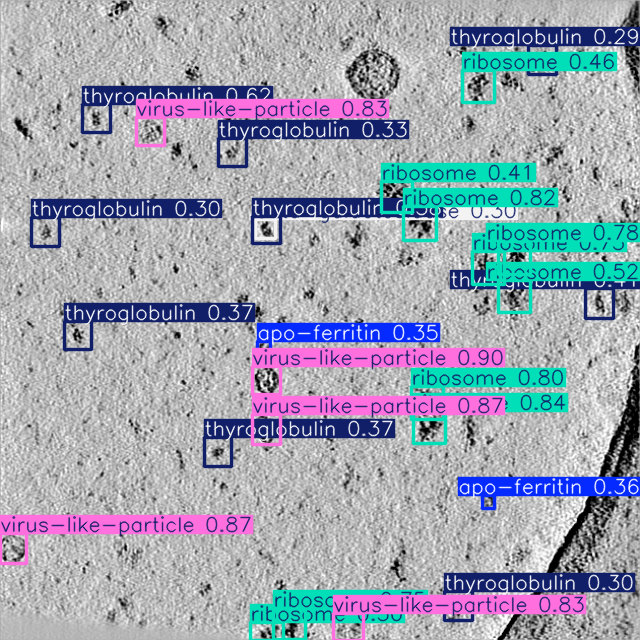

In [ ]:
results = model('/content/drive/My Drive/project3/czii-cryo-et-object-identification/datasets/czii_det2d/images/val/TS_5_4_920.png')
results[0].show()

# Prediction example


image 1/1 /content/drive/My Drive/project3/czii-cryo-et-object-identification/datasets/czii_det2d/images/val/TS_5_4_960.png: 640x640 1 apo-ferritin, 2 beta-galactosidases, 10 ribosomes, 8 thyroglobulins, 4 virus-like-particles, 22.5ms
Speed: 2.2ms preprocess, 22.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


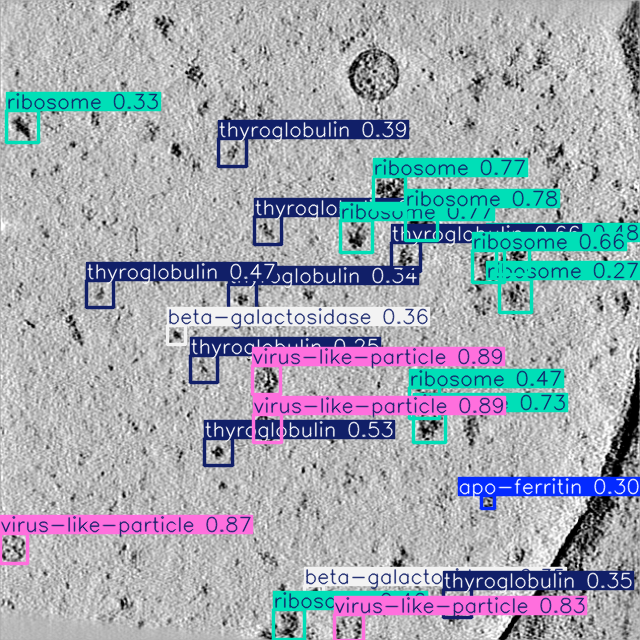

In [ ]:
results = model('/content/drive/My Drive/project3/czii-cryo-et-object-identification/datasets/czii_det2d/images/val/TS_5_4_960.png')
results[0].show()

# Continue to [Submission Baseline...](https://www.kaggle.com/code/itsuki9180/czii-yolo11-submission-baseline)